# PiML Toolbox: High-code Demo for BikeSharing Data

This example notebook demonstrates how to use PiML with its high-code APIs for developing machine learning models for the BikeSharing data from UCI repository, which consists of 17,389 samples of hourly counts of rental bikes in Capital bikeshare system; see details [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset). 

The response `cnt` (hourly bike rental counts) is continuous and it is a regression problem.

# Stage 0: Install PiML package on Google Colab

1. Run `!pip install piml` to install the latest version of PiML. It requires V0.2 or above to use high-code APIs.
2. In Colab, you'll need restart the runtime in order to use newly installed PiML version.

In [ ]:
!pip install piml

# Stage 1: Initialize an experiment, Load and Prepare data

In [ ]:
from piml import Experiment
exp = Experiment()

In [ ]:
exp.data_loader(data='BikeSharing')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,16.0
1,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,40.0
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,32.0
3,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,13.0
4,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,1.0,12.0,19.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,119.0
17375,1.0,1.0,12.0,20.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,89.0
17376,1.0,1.0,12.0,21.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642,90.0
17377,1.0,1.0,12.0,22.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343,61.0


In [ ]:
exp.data_summary(feature_type={}, feature_exclude=["season", "workingday", "atemp"])

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='Data Shape:(17379, 13)')

In [ ]:
exp.data_prepare(target='cnt', task_type='Regression', test_ratio=0.2, random_state=0)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Output()

,0,1
0,Inactive columns name,"[season, workingday, atemp]"
1,Target colunm name,cnt
2,Task type,Regression
3,Test ratio,0.2
4,Random state,0


In [ ]:
exp.eda(show='all', uni_feature='temp', bi_features=['hr', 'cnt'],  multi_type='correlation_heatmap')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Stage 2. Train intepretable models

In [ ]:
## ReLU-DNN: ReLU Deep Neural Networks with L1-Regularization
from piml.models import ReluDNNRegressor

clf1 = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf1, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register ReLU-DNN Done</p>")

,,MSE,MAE,R2
0,Train,0.003915,0.043008,0.886470
1,Test,0.004556,0.046019,0.870214
2,Gap,0.000641,0.003011,-0.016256


In [ ]:
## GAMI-Net: GAM-Neural Networks with Structured Interactions
from piml.models import GAMINetRegressor

clf2 = GAMINetRegressor(interact_num=10, loss_threshold=0.01,  
                        subnet_size_main_effect=[20], 
                        subnet_size_interaction=[20,20])
exp.model_train(model=clf2, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register GAMI-Net Done</p>")

,,MSE,MAE,R2
0,Train,0.003238,0.039444,0.906110
1,Test,0.003597,0.041875,0.897519
2,Gap,0.000360,0.002431,-0.008591


In [ ]:
## EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

clf3 = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=clf3, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register EBM Done</p>")

,,MSE,MAE,R2
0,Train,0.006317,0.055269,0.816823
1,Test,0.006871,0.057656,0.804265
2,Gap,0.000554,0.002387,-0.012558


In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='accuracy')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Stage 3. Explain and Interpret

## Post-hoc Explaination: Global and Local Methods

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

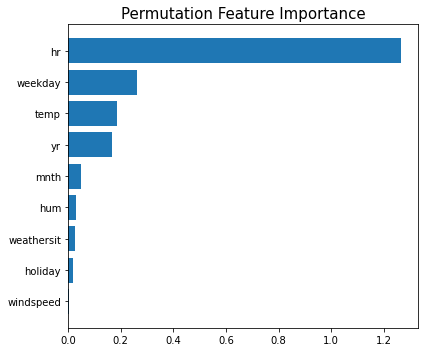

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_pfi', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

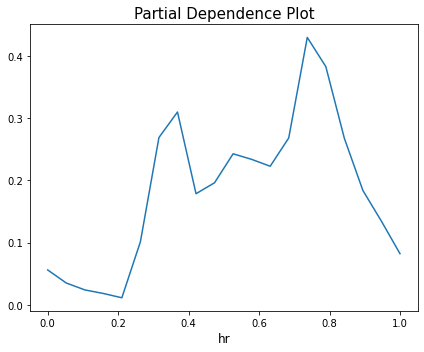

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_pdp', uni_feature='hr', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

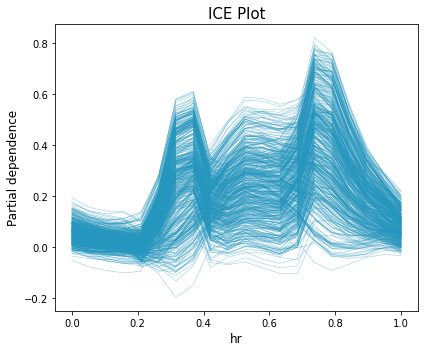

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_ice', uni_feature="hr", figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

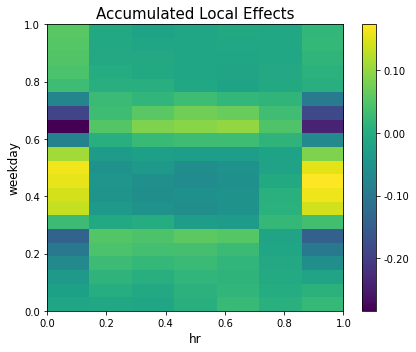

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_ale', bi_features=['hr', 'weekday'], figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

  0%|          | 0/50 [00:00<?, ?it/s]

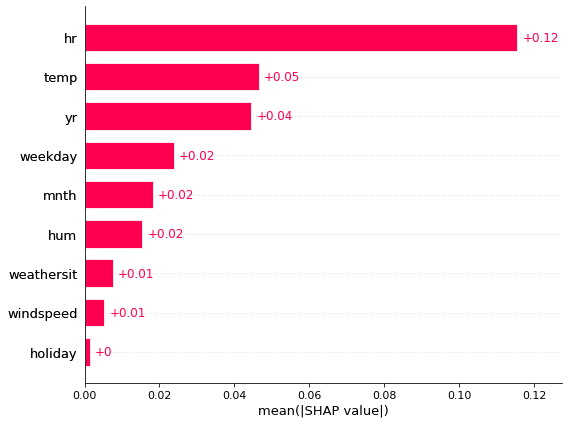

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_shap_fi', sample_size=50)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

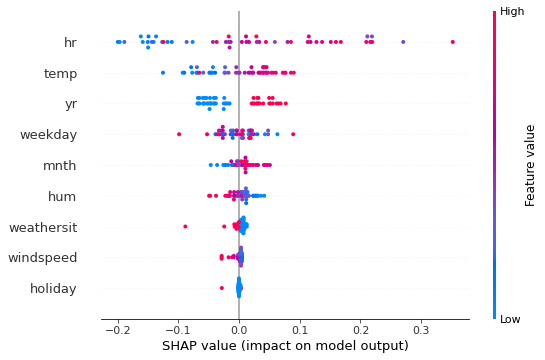

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_shap_summary', 
                  sample_size=50)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

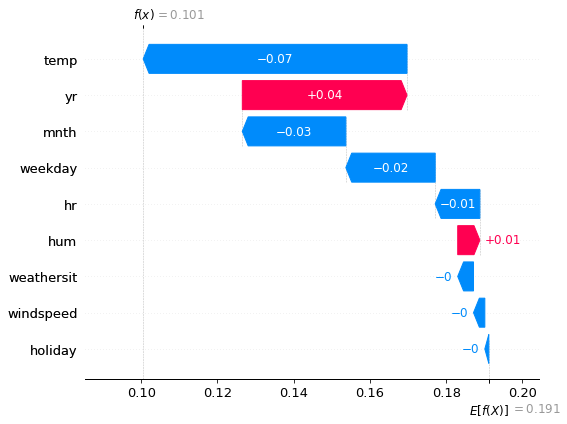

In [ ]:
exp.model_explain(model='GAMI-Net', show='local_shap', sample_id=0)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

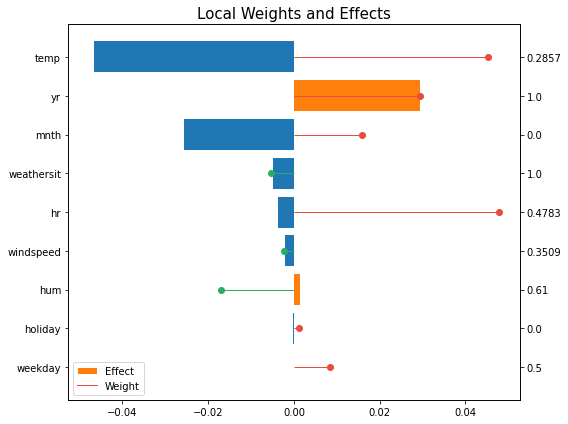

In [ ]:
exp.model_explain(model='GAMI-Net', show='local_lime', sample_id=0)

## Inherent Interpretation: Global and Local Methods
 


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

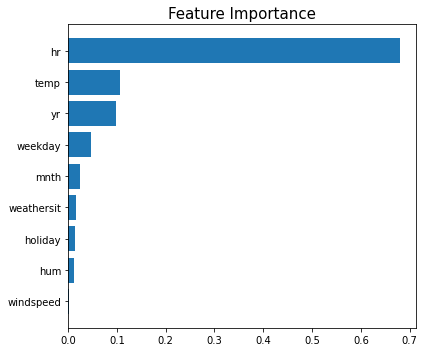

In [ ]:
exp.model_interpret(model='GAMI-Net', show='global_fi', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

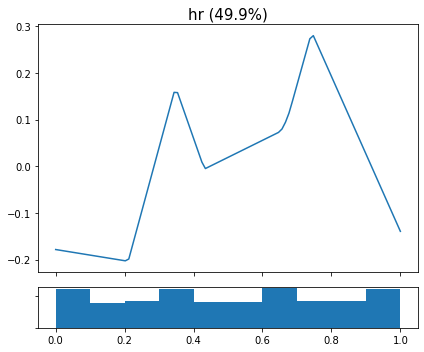

In [ ]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', uni_feature='hr', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

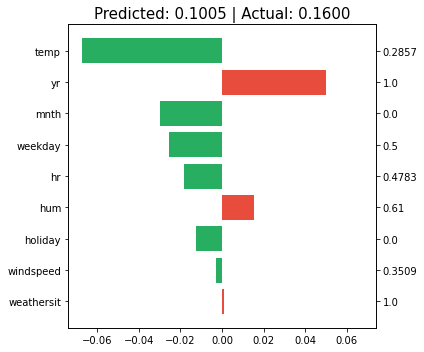

In [ ]:
exp.model_interpret(model='GAMI-Net', show='local_fi', sample_id=0, figsize=(6,5))

# Stage 4. Diagnose and Compare

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,,MSE,MAE,R2
0,Train,0.003238,0.039444,0.906110
1,Test,0.003597,0.041875,0.897519
2,Gap,0.000360,0.002431,-0.008591


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

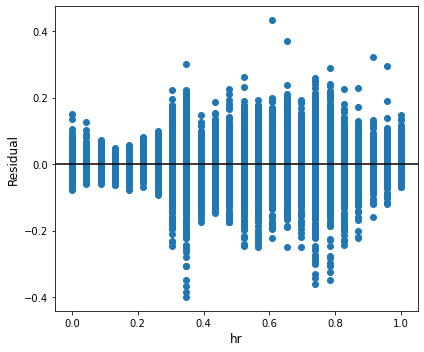

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_residual', target_feature='hr', figsize=(6, 5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

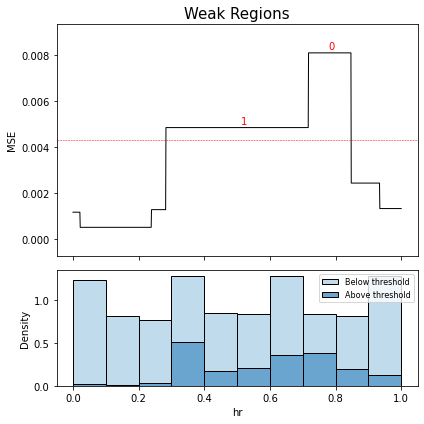

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot_plot', slice_features=['hr'], 
                   slice_method='tree', threshold=1.2, min_sample=20, figsize=(6, 6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

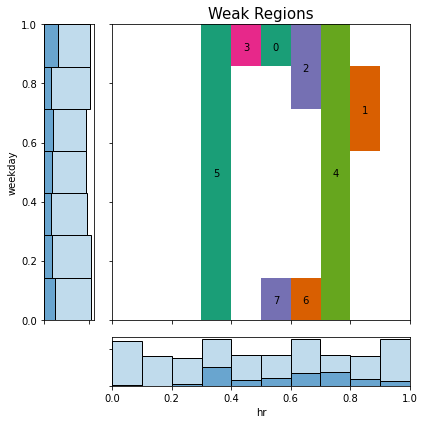

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot_plot', slice_features=['hr', 'weekday'], 
                   slice_method='histogram', threshold=1.2, min_sample=20, figsize=(6, 6))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot_result', slice_features=['hr', 'weekday'], 
                   slice_method='histogram', threshold=1.2, min_sample=20)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Weak Regions cut-off at test MSE: 0.00432


,[hr,hr),[weekday,weekday),#Test,#Train,test_MSE,train_MSE,Gap
0,0.5,0.6,0.857143,1.000000,35,175,0.016285,0.009952,0.006333
1,0.8,0.9,0.571429,0.857143,83,333,0.005132,0.003594,0.001538
2,0.6,0.7,0.714286,1.000000,121,506,0.006774,0.005312,0.001462
3,0.4,0.5,0.857143,1.000000,45,165,0.006818,0.005639,0.001179
4,0.7,0.8,0.000000,1.000000,290,1168,0.009315,0.008636,0.000679
5,0.3,0.4,0.000000,1.000000,445,1736,0.006271,0.005848,0.000423
6,0.6,0.7,0.000000,0.142857,73,242,0.005749,0.006511,-0.000762
7,0.5,0.6,0.000000,0.142857,41,169,0.007322,0.008459,-0.001138


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

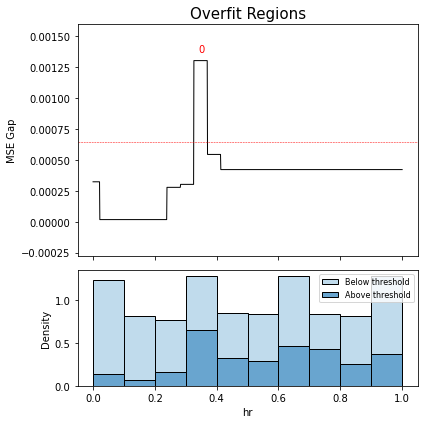

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='overfit_plot', slice_features=['hr'], 
                   slice_method='tree', threshold=1.2, min_sample=20, figsize=(6, 6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

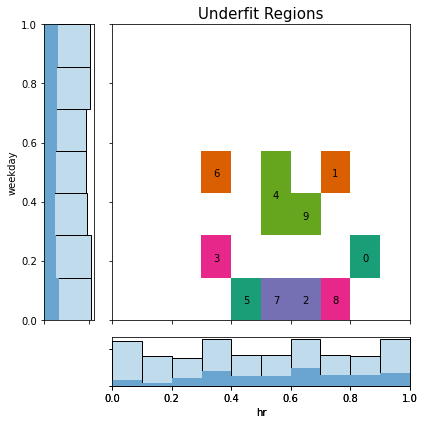

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='underfit_plot', slice_features=['hr', 'weekday'], 
                   slice_method='histogram', threshold=1.2, min_sample=20, figsize=(6, 6))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='reliability', alpha=0.9, 
                   target_feature='hr', threshold=1.2, bins=10)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='robustness', perturb_features='All Features',
                   step=0.01, alpha=0.2)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='resilience', immu_feature='None', 
                   target_feature='hr', alpha=0.2)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

Box(children=(HBox(children=(Box(children=(VBox(children=(Output(), Output())),), layout=Layout(width='36%')),…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

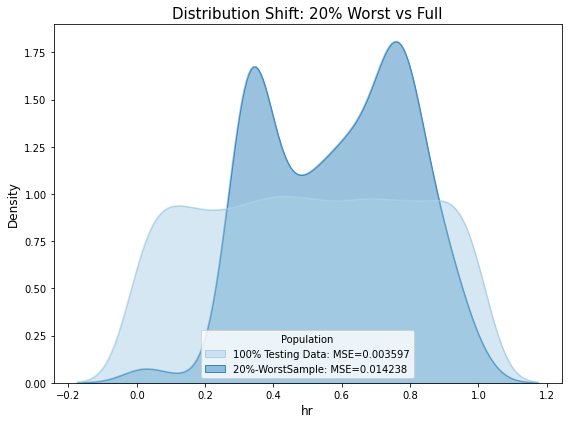

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='resilience_shift_density', immu_feature='mnth', 
                   target_feature='hr', alpha=0.2, figsize=(8,6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

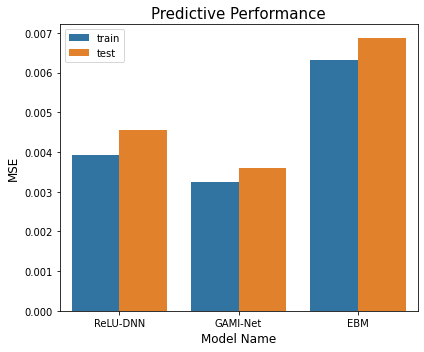

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='accuracy_mse', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

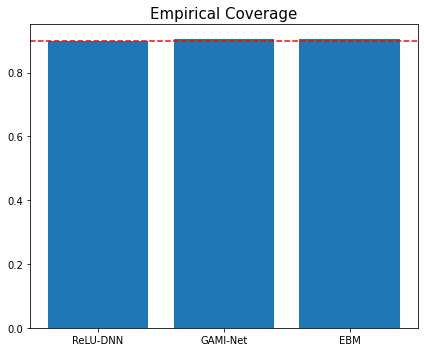

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_coverage', 
                  alpha=0.1, figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

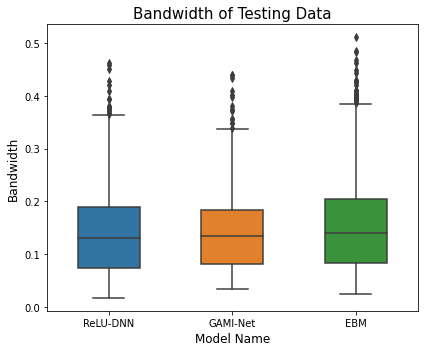

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_bandwidth', 
                  alpha=0.1, figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

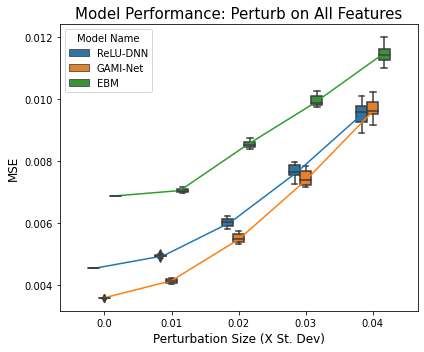

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf', 
                  perturb_features='All Features', step=0.01, figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

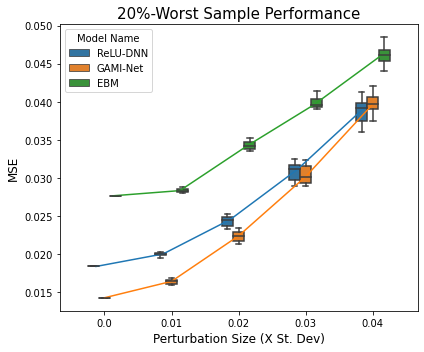

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf_worst', 
                  perturb_features='All Features', step=0.01, alpha=0.2, figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

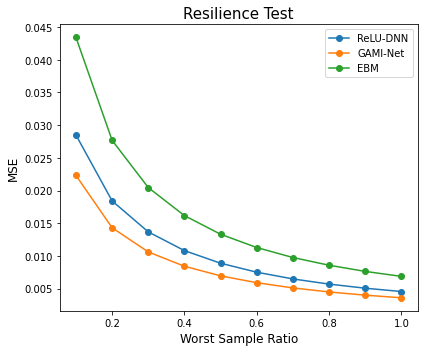

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_perf', 
                  immu_feature='None', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

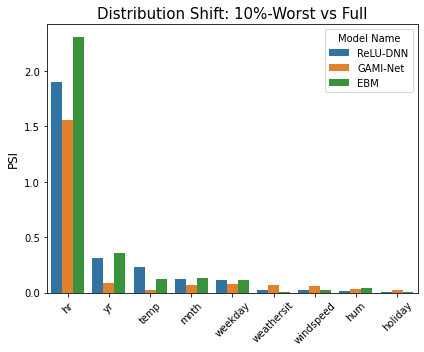

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_psi', 
                  immu_feature='None', figsize=(6,5))

# Stage 5. Register an arbitrary model ...

In [ ]:
from lightgbm import LGBMRegressor

clf = LGBMRegressor(max_depth=7, n_estimators=500)
pipeline = exp.make_pipeline(model=clf, name='LightGBM')
pipeline.fit()
exp.register(pipeline=pipeline)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register LightGBM Done</p>")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

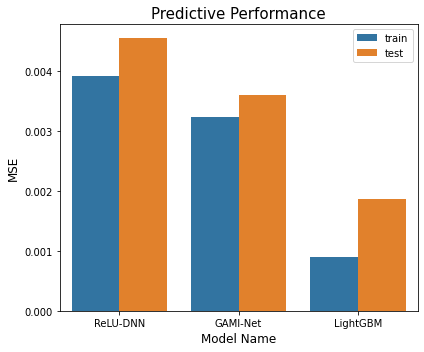

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'LightGBM'], show='accuracy_mse', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

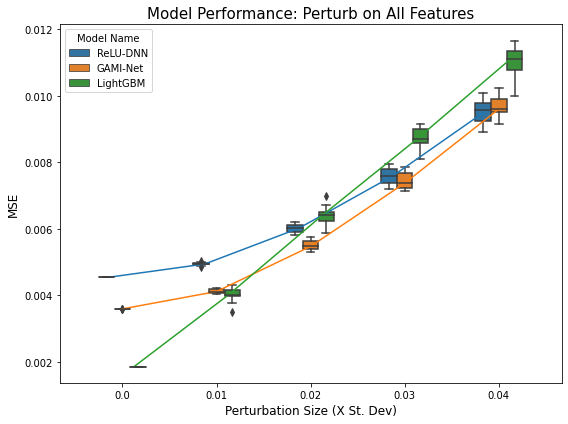

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'LightGBM'], show='robustness_perf', 
                  perturb_features='All Features', step=0.01, figsize=(8,6))